# Exercise Sheet 2 - CIFAR, MLP, Overfitting, and Regularization

 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
 * Due date: **Tue, 1. Dec 20, 2:15pm**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.


## Imports

In [3]:
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

### GPU and Cuda checks

In [4]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [5]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
2 CPUs available


**Recommendation:** Use GPU or TPU for faster model training. Exercise sheet 1 explains how to do that on Colab.

## Load data

In [6]:
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [7]:
####################
## YOUR CODE HERE ##
####################

trainset, testset, dataset_mean, dataset_std = grab_data('./data', num_cpus=1)

Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)

In [9]:
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1)

Let's have a look at the dataset.

#### TODO
- Print all class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [10]:
classes = ['airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
print(dataset_mean, dataset_std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

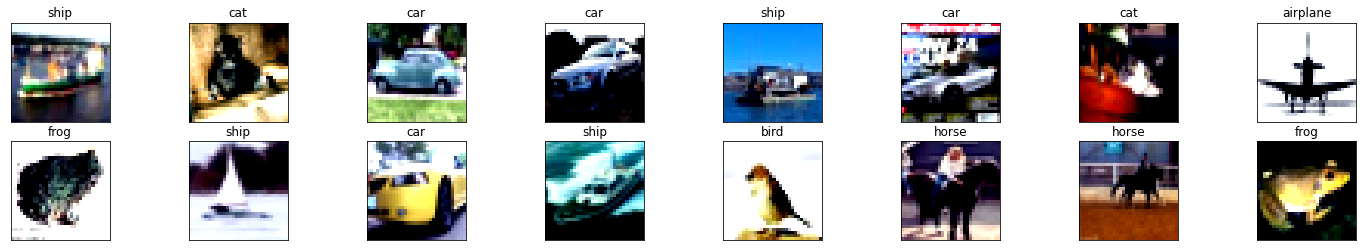

In [13]:
####################
## YOUR CODE HERE ##
####################

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#image = images.numpy()

fig = plt.figure(figsize=(25,4))
#display 16 images
for idx in range(16):
  ax = fig.add_subplot(2,16/2,idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## Training, evaluation and plotting functions from Exercise 1

Here, we provide examples of the functions you implemented on the first exercise sheet to you. Some parts are still missing. You can ignore that for the time being, as you will implement that later as soon as the according functionality is required.

In [15]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        x_device = x.to(device)
        y_pred = model(x_device)

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.counter == 0:
                early_stopper.save_checkpoint(model, epoch_val_acc)
            if early_stopper.early_stop:
                early_stopper.load_checkpoint(model)
                break

            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot([extra_pt[0]], [extra_pt[1]], marker='s')
        if extra_pt_label:
            legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity in the input layer and in the hidden layers, but not after the output layer

*Hint*: As CIFAR 10 is a color image, amongst other dimensions you want to flatten the color channel dimension, too.

In [16]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """

        super(MLP, self).__init__()

        input_size = img_width * img_width * num_in_channels

        if act_fn is None:
            act_fn = nn.ReLU

        layers_list = [act_fn(),
                  nn.Linear(input_size, num_hidden_units).cuda(),
                  act_fn().cuda()
                  ]
        for _ in range(num_hidden_layers - 1):
            layers_list.append(nn.Linear(num_hidden_units, num_hidden_units).cuda())
            layers_list.append(act_fn().cuda())
        layers_list.append(nn.Linear(num_hidden_units, num_classes).cuda())

        self.layers = nn.Sequential(*layers_list)

        # print("Created model with layers:\n{}".format(self.layers))

    
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """

        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we do not use SGD as in exercise 1, but the commonly used Adam optimizer, since it behaves very robustly and is easy to use.

#### TODO
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

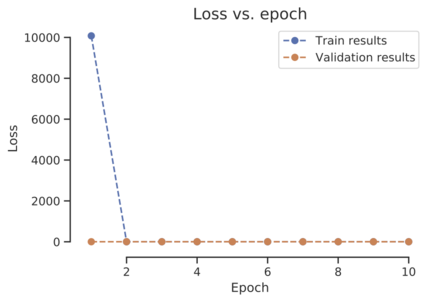

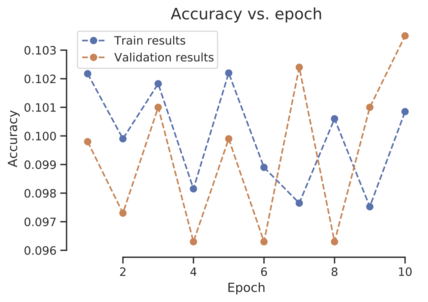

**This is an example of a model that does train:** *(Why?)*

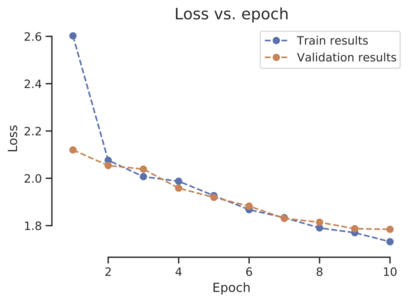

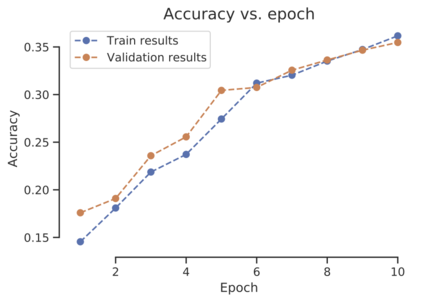

In [17]:
img_width = 32
num_in_channels = 3
num_classes = 10

model = MLP(img_width, num_in_channels, num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**0)
num_epochs = 10

train_dataloader, val_dataloader, test_dataloader = init_data_loaders(trainset, valset, testset)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

Finished training after 116 seconds.


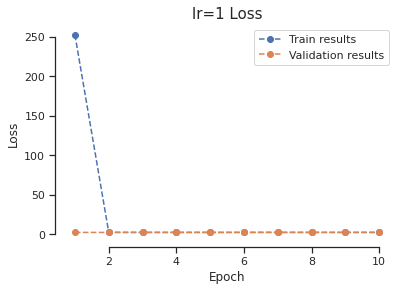

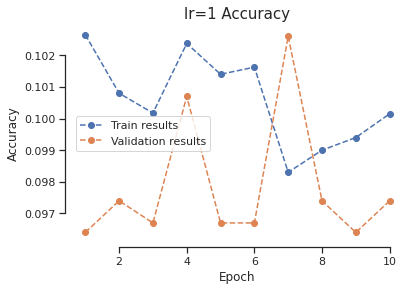

In [ ]:
plot("lr=1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

In [ ]:
model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-1) # changed lr from 1 to 0.1

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

plot("lr=0.1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 104 seconds.


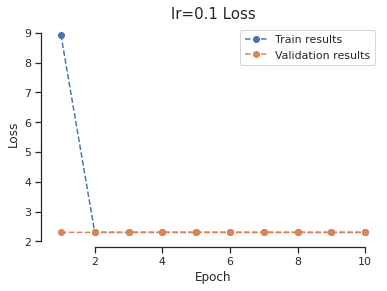

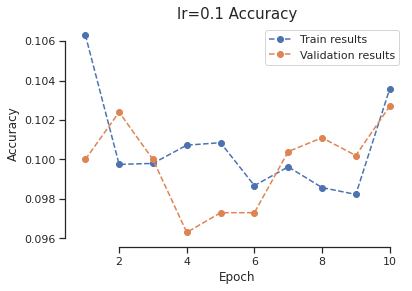

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 104 seconds.


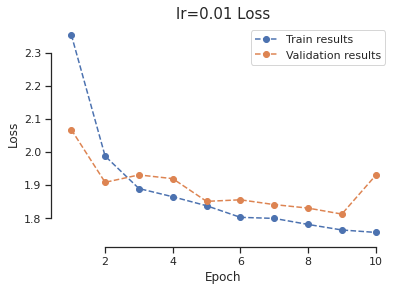

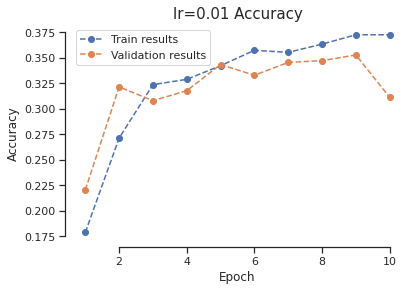

In [ ]:
model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

plot("lr=0.01 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.01 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your todo's:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 1035 seconds.


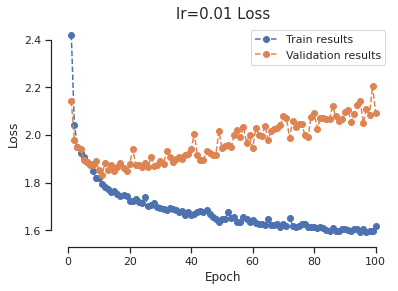

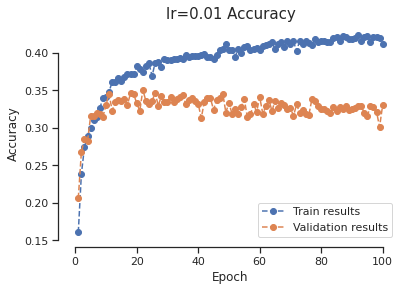

In [ ]:
model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

plot("lr=0.01 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.01 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

In [18]:
def print_best_loss_and_accuracy(val_losses, val_accs):
    print("Best validation loss: {} at epoch {}".format(min(val_losses), np.argmin(val_losses) + 1))
    print("Best validation accuracy: {} at epoch {}".format(max(val_accs), np.argmax(val_accs) + 1))

In [ ]:
print_best_loss_and_accuracy(val_losses, val_accs)

Best validation loss: 1.8337895631790162 at epoch 11
Best validation accuracy: 0.3509 at epoch 22


Let's have a look at those training curves! Here are some questions for you.

#### TODO
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. The training loss generally decreases, but it does not decrease after each epoch. This is because the optimizer may move in the wrong direction, or overshoot if it is moving in the right direction.

2. The validation loss initially decreases for the first 10 epochs. The network is learning features that generalise well over the validation set. After this, the model begins to overfit. At this point the accuracy decreases slightly, and the overall trend for the validation loss is that it gets worse.

3. The training accuracy generally gets better with few fluctuations. This is because the optimizer is trying to lower loss by improving accuracy. The validation accuracy first increases because the model is learning, but decreases once the models starts to overfit.

4. No.

5. There is a difference because cross-entropy does not only look at the prediction, but also the confidence of that prediction.

6. I would use the model with the lowest validation loss (epoch 11), as it gave the best results on the unseen test data. I would not pick the model with the lowest training loss, since this is caused by overfitting.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [ ]:
# save

torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, "model")


In [19]:
def val_acc(model):
    epoch_correct, epoch_total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(val_dataloader):
            y_pred = model(x.to(device))
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

    return accuracy(epoch_correct, epoch_total)

In [ ]:
model2 = MLP(img_width, num_in_channels, num_classes)

val_acc(model2)

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


0.1011

In [ ]:
# loading the checkpoint
checkpoint = torch.load("model")
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

val_acc(model2)

0.3305

## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [20]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accyracy does not increase, stop training early. 
                Defaults to 1.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.__early_stop = False
        self.val_acc_max = -np.Inf
        self.path = path
        
        
    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        return self.counter >= self.patience

        
        
    def update(self, val_acc, model):
        """Call after one epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        if val_acc > self.val_acc_max:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1


            
    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')

        self.val_acc_max = val_acc
        torch.save({
            'model_state_dict': model.state_dict()
            }, self.path)

        
        
        
    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        if self.verbose:
            print(f'Loading model from last checkpoint with validation accuracy {self.val_acc_max:.6f}')

        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])


#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [ ]:
model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
early_stopper = EarlyStopper(verbose=True)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Validation accuracy increased (-inf --> 0.174200).  Saving model ...
Validation accuracy increased (0.174200 --> 0.210500).  Saving model ...
Validation accuracy increased (0.210500 --> 0.293200).  Saving model ...
Validation accuracy increased (0.293200 --> 0.315600).  Saving model ...
Loading model from last checkpoint with validation accuracy 0.315600
Finished training after 80 seconds.


Best validation loss: 1.9100552320480346 at epoch 5
Best validation accuracy: 0.3156 at epoch 4
4 0.3156


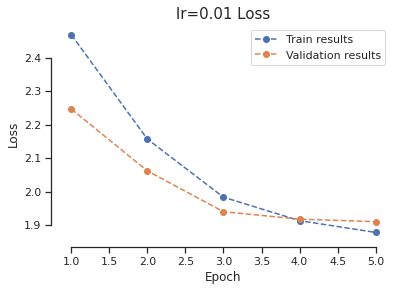

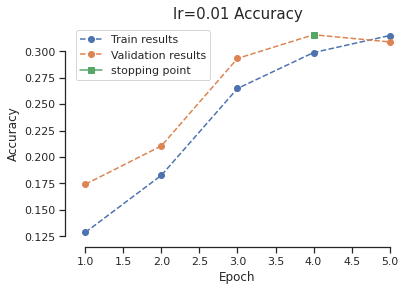

In [ ]:
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

print(x, y)

plot("lr=0.01 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.01 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="stopping point")

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?



*   The model did not reach best performance. This is because the patience was too low.
*   The model with patience=10 was almost as good as the best validation accuracy (0.3428 vs 0.3509). But only needed to train 40 epochs. The difference in performance might be due to randomness.



In [ ]:
model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
early_stopper = EarlyStopper(verbose=True, patience=10)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Validation accuracy increased (-inf --> 0.200600).  Saving model ...
Validation accuracy increased (0.200600 --> 0.212200).  Saving model ...
Validation accuracy increased (0.212200 --> 0.240100).  Saving model ...
Validation accuracy increased (0.240100 --> 0.274800).  Saving model ...
Validation accuracy increased (0.274800 --> 0.279500).  Saving model ...
Validation accuracy increased (0.279500 --> 0.284200).  Saving model ...
Validation accuracy increased (0.284200 --> 0.298900).  Saving model ...
Validation accuracy increased (0.298900 --> 0.322600).  Saving model ...
Validation accuracy increased (0.322600 --> 0.327500).  Saving model ...
Validation accuracy increased (0.327500 --> 0.333400).  Saving model ...
Validation accuracy increased (0.333400 --> 0.336300).  Saving model ...
Validation accuracy increased (0.336300 --> 0.337100).  Saving model ...
Validation accuracy increased (0.337100 --> 0.342800).  Saving model ...
Loading model from last checkpoint with validation accu

Best validation loss: 1.8532811284065247 at epoch 24
Best validation accuracy: 0.3428 at epoch 29


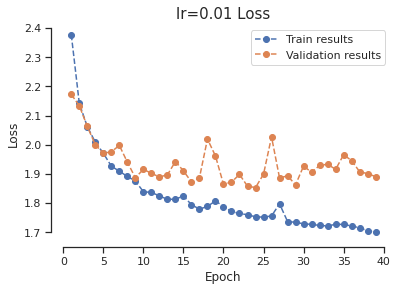

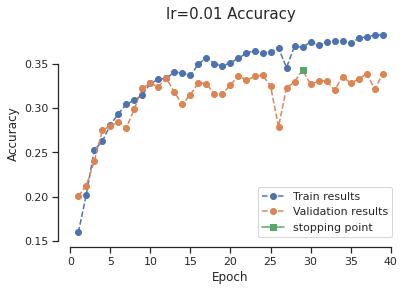

In [ ]:
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

plot("lr=0.01 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.01 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="stopping point")

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa5fa853208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa5fa853208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Finished training after 586 seconds.
Best validation loss: 1.6640469193458558 at epoch 31
Best validation accuracy: 0.4186 at epoch 26
26 0.4186


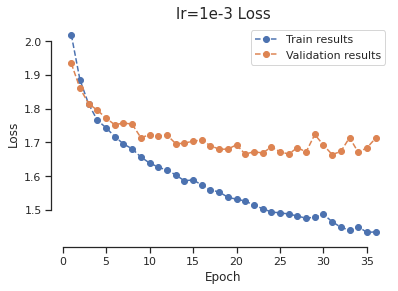

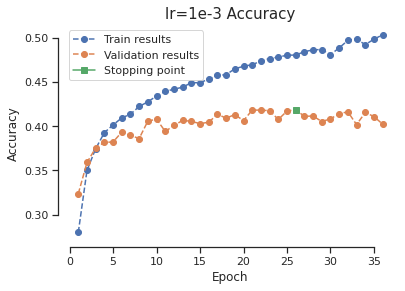

In [ ]:
lr = 1e-3

model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 100
early_stopper = EarlyStopper(patience=10)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

print(x, y)

plot("lr=1e-3 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-3 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")


Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa5f9553390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa5f9553390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Finished training after 1628 seconds.
Best validation loss: 1.665994608402252 at epoch 100
Best validation accuracy: 0.4278 at epoch 92
92 0.4278


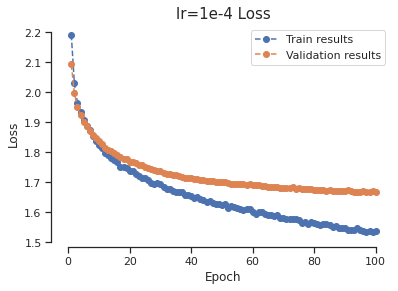

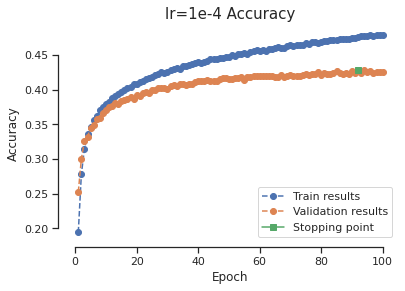

In [ ]:
lr = 1e-4

model = MLP(img_width, num_in_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 100
early_stopper = EarlyStopper(patience=10)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

print(x, y)

plot("lr=1e-4 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-4 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")


The 1e-4 and 1e-3 models performed similarly well, and did better than the 1e-2 model. The 1e-4 model trained slower than the other two. I would choose lr=1e-3 since it was the fastest and produced the best model.

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
)


Finished training after 532 seconds.
Best validation loss: 1.7980135798454284 at epoch 28
Best validation accuracy: 0.3687 at epoch 23


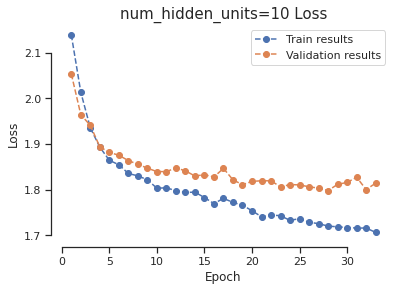

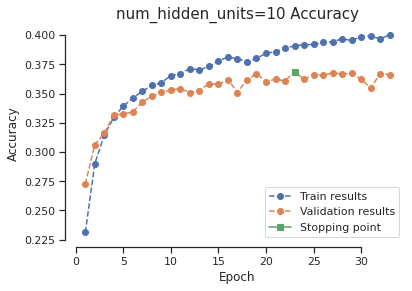

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 516 seconds.
Best validation loss: 1.672246789932251 at epoch 22
Best validation accuracy: 0.4221 at epoch 22


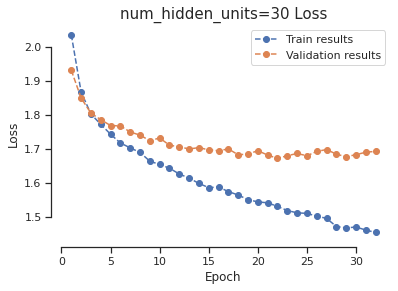

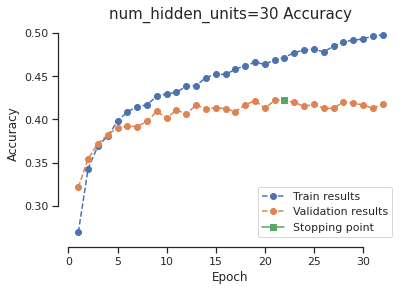

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
)


Finished training after 435 seconds.
Best validation loss: 1.6411612033843994 at epoch 22
Best validation accuracy: 0.4288 at epoch 17


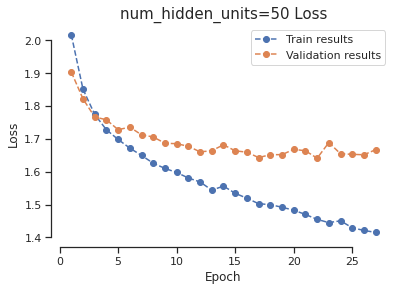

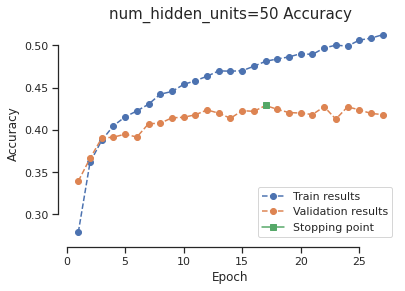

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=75, bias=True)
  (2): ReLU()
  (3): Linear(in_features=75, out_features=10, bias=True)
)


Finished training after 532 seconds.
Best validation loss: 1.6008702397346497 at epoch 15
Best validation accuracy: 0.4542 at epoch 23


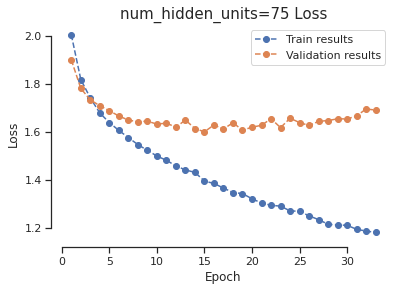

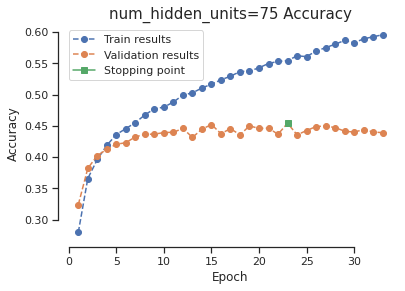

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
)


Finished training after 503 seconds.
Best validation loss: 1.5763054966926575 at epoch 16
Best validation accuracy: 0.459 at epoch 21


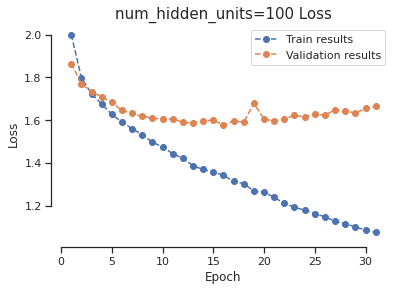

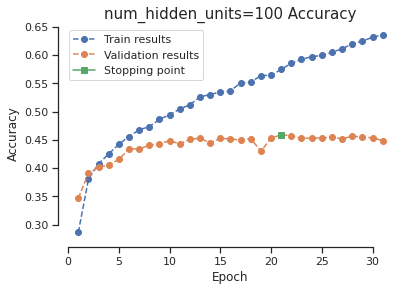

In [ ]:
# number of hidden units

lr = 1e-3

for num_hidden_units in [10, 30, 50, 75, 100]:

    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=num_hidden_units, num_hidden_layers=1, act_fn=None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 100
    early_stopper = EarlyStopper(patience=10)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
        )
    print_best_loss_and_accuracy(val_losses, val_accs)
    x, y = np.argmax(val_accs) + 1, max(val_accs)

    plot("num_hidden_units={} Loss".format(num_hidden_units), "Loss", train_losses, val_losses, yscale='linear')
    plot("num_hidden_units={} Accuracy".format(num_hidden_units), "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")


Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=10, bias=True)
)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa685b3d0f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa685b3d0f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Finished training after 487 seconds.
Best validation loss: 1.651954996585846 at epoch 21
Best validation accuracy: 0.4314 at epoch 20


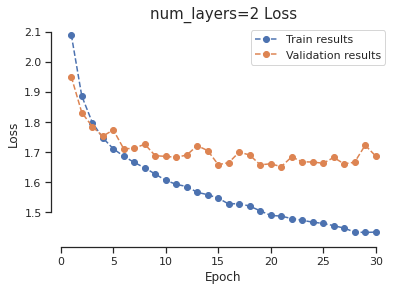

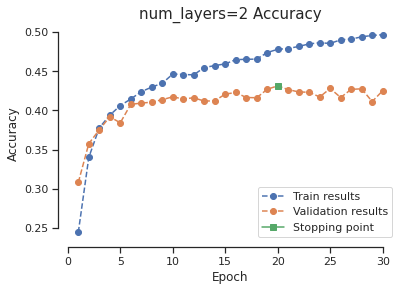

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=30, bias=True)
  (6): ReLU()
  (7): Linear(in_features=30, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=30, bias=True)
  (10): ReLU()
  (11): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 690 seconds.
Best validation loss: 1.6673444151878356 at epoch 26
Best validation accuracy: 0.4176 at epoch 32


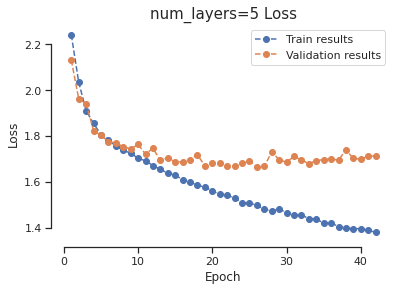

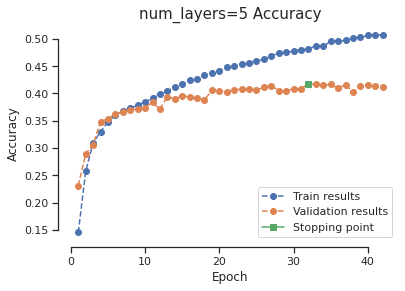

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=30, bias=True)
  (6): ReLU()
  (7): Linear(in_features=30, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=30, bias=True)
  (10): ReLU()
  (11): Linear(in_features=30, out_features=30, bias=True)
  (12): ReLU()
  (13): Linear(in_features=30, out_features=30, bias=True)
  (14): ReLU()
  (15): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 757 seconds.
Best validation loss: 1.6684348583221436 at epoch 36
Best validation accuracy: 0.4154 at epoch 36


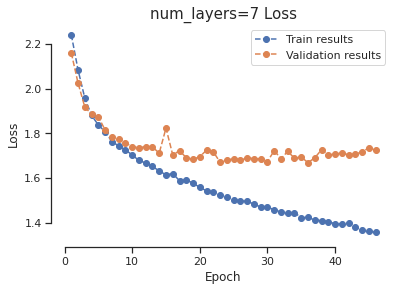

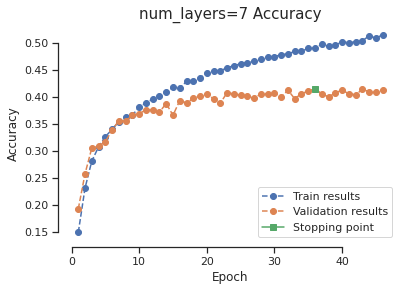

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=30, bias=True)
  (6): ReLU()
  (7): Linear(in_features=30, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=30, bias=True)
  (10): ReLU()
  (11): Linear(in_features=30, out_features=30, bias=True)
  (12): ReLU()
  (13): Linear(in_features=30, out_features=30, bias=True)
  (14): ReLU()
  (15): Linear(in_features=30, out_features=30, bias=True)
  (16): ReLU()
  (17): Linear(in_features=30, out_features=30, bias=True)
  (18): ReLU()
  (19): Linear(in_features=30, out_features=30, bias=True)
  (20): ReLU()
  (21): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 824 seconds.
Best validation loss: 1.7682986974716186 at epoch 32
Best validation accuracy: 0.3795 at epoch 40


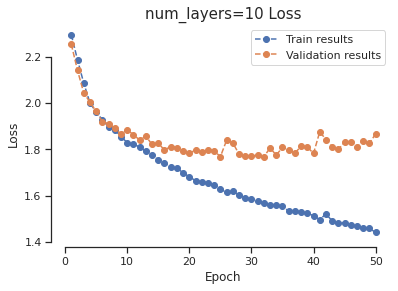

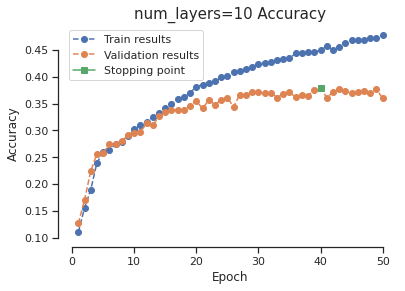

Created model with layers:
Sequential(
  (0): ReLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=30, bias=True)
  (6): ReLU()
  (7): Linear(in_features=30, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=30, bias=True)
  (10): ReLU()
  (11): Linear(in_features=30, out_features=30, bias=True)
  (12): ReLU()
  (13): Linear(in_features=30, out_features=30, bias=True)
  (14): ReLU()
  (15): Linear(in_features=30, out_features=30, bias=True)
  (16): ReLU()
  (17): Linear(in_features=30, out_features=30, bias=True)
  (18): ReLU()
  (19): Linear(in_features=30, out_features=30, bias=True)
  (20): ReLU()
  (21): Linear(in_features=30, out_features=30, bias=True)
  (22): ReLU()
  (23): Linear(in_features=30, out_features=30, bias=True)
  (24): ReLU()
  (25): Linear(in_features=30, out_features=30, bias=True)
  (26):

Finished training after 897 seconds.
Best validation loss: 1.8292341470718383 at epoch 22
Best validation accuracy: 0.3535 at epoch 44


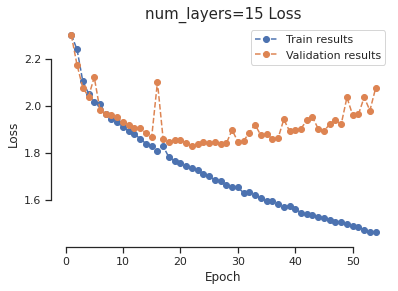

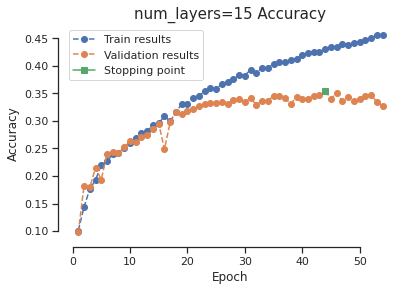

In [ ]:
# number of layers

lr = 1e-3

for num_layers in [2, 5, 7, 10, 15]:

    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=num_layers, act_fn=None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 100
    early_stopper = EarlyStopper(patience=10)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
        )
    print_best_loss_and_accuracy(val_losses, val_accs)
    x, y = np.argmax(val_accs) + 1, max(val_accs)

    plot("num_layers={} Loss".format(num_layers), "Loss", train_losses, val_losses, yscale='linear')
    plot("num_layers={} Accuracy".format(num_layers), "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")


Created model with layers:
Sequential(
  (0): SiLU()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): SiLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa6198533c8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa6198533c8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Finished training after 517 seconds.
Best validation loss: 1.5770378232002258 at epoch 23
Best validation accuracy: 0.4523 at epoch 22


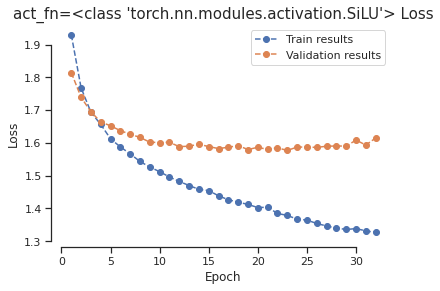

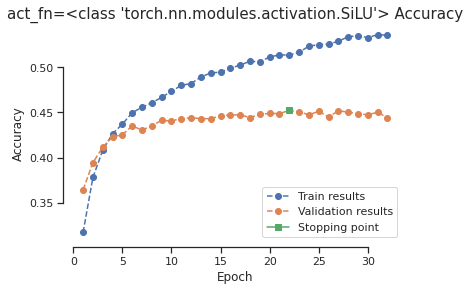

Created model with layers:
Sequential(
  (0): Sigmoid()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 1627 seconds.
Best validation loss: 1.572387170791626 at epoch 98
Best validation accuracy: 0.4452 at epoch 100


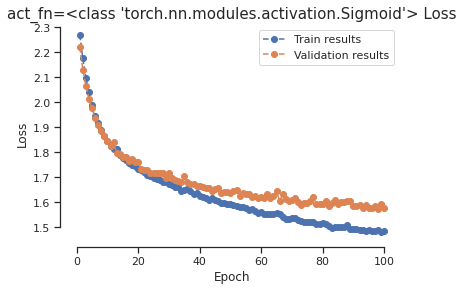

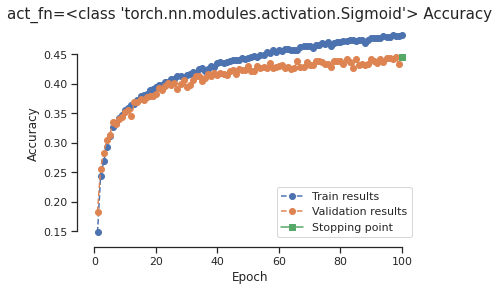

Created model with layers:
Sequential(
  (0): Tanh()
  (1): Linear(in_features=3072, out_features=30, bias=True)
  (2): Tanh()
  (3): Linear(in_features=30, out_features=10, bias=True)
)


Finished training after 309 seconds.
Best validation loss: 1.66319797039032 at epoch 14
Best validation accuracy: 0.4297 at epoch 9


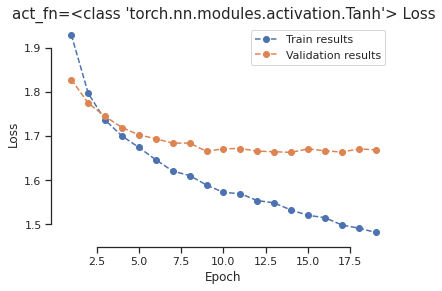

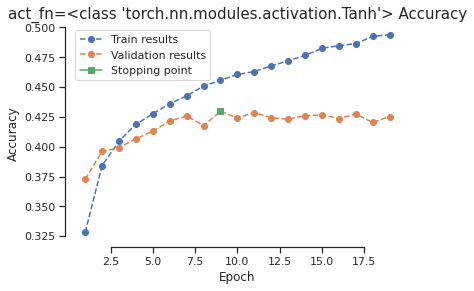

In [ ]:
# activation function

lr = 1e-3

for act_fn in [nn.SiLU, nn.Sigmoid, nn.Tanh]:

    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=act_fn)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 100
    early_stopper = EarlyStopper(patience=10)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
        )
    print_best_loss_and_accuracy(val_losses, val_accs)
    x, y = np.argmax(val_accs) + 1, max(val_accs)

    plot("act_fn={} Loss".format(act_fn), "Loss", train_losses, val_losses, yscale='linear')
    plot("act_fn={} Accuracy".format(act_fn), "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- The best model was the model with 100 hidden units, which has an accuracy of 0.459.
- The hyper-parameter that made the largest difference is the number of hidden units. A lower number greatly reduced the accuracy, while a greater number gave better results.
- It does not always help to make the model bigger. For example, increasing the number of hidden layers past 5 reduced the accuracy. This is because the increased number of parameters leads to more overfitting.

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

In [21]:
# Best hyper-parameters (independent)

model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=100, num_hidden_layers=2, act_fn=nn.SiLU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
early_stopper = EarlyStopper(patience=10)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

Finished training after 306 seconds.
Best validation loss: 1.4687011957168579 at epoch 12
Best validation accuracy: 0.5021 at epoch 16


NameError: ignored

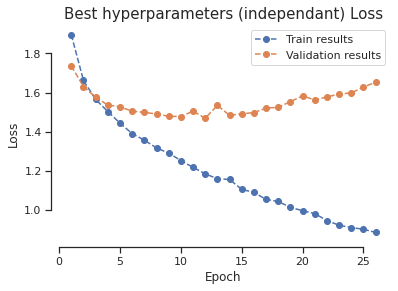

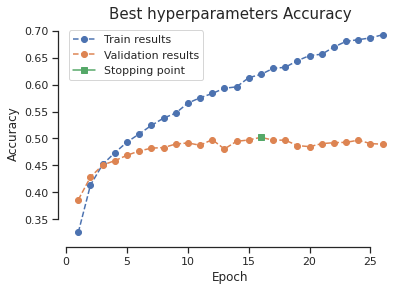

In [22]:
plot("Best hyperparameters (independant) Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Best hyperparameters Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")

In [ ]:
# Best hyper-parameter search

from random import choice

hidden_unit_list = list(range(50, 300))
num_hidden_layers_list = list(range(1, 10))
act_fns = [nn.ReLU, nn.SiLU, nn.Sigmoid]

# We train 50 models with hyperparameters randomly chosen from the lists and pick the best.

hyperparams = dict()
best_hyperparams = dict()
best_hyperparams_acc = 0

for _ in range(50):

    hidden_units = choice(hidden_unit_list)
    hidden_layers = choice(num_hidden_layers_list)
    act = choice(act_fns)

    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=hidden_units, num_hidden_layers=hidden_layers, act_fn=act)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 100
    early_stopper = EarlyStopper(patience=10)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
        )

    hyperparams = {
            "num_hidden_units": hidden_units,
            "num_hidden_layers": hidden_layers,
            "act_fn": act,
            "accuracy": max(val_accs)
    }
    print(hyperparams)
    print_best_loss_and_accuracy(val_losses, val_accs)

    if max(val_accs) > best_hyperparams_acc:
        best_hyperparams_acc = max(val_accs)
        best_hyperparams = hyperparams

    print("best hyperparameters found:")
    print(best_hyperparams)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa679935278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa679935278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Finished training after 1245 seconds.
{'num_hidden_units': 146, 'num_hidden_layers': 5, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.2821}
Best validation loss: 1.8753562927246095 at epoch 58
Best validation accuracy: 0.2821 at epoch 66
best hyperparameters found:
{'num_hidden_units': 146, 'num_hidden_layers': 5, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.2821}


Finished training after 1630 seconds.
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}
Best validation loss: 1.3728198289871216 at epoch 89
Best validation accuracy: 0.517 at epoch 96
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 376 seconds.
{'num_hidden_units': 176, 'num_hidden_layers': 4, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.5154}
Best validation loss: 1.4380452513694764 at epoch 7
Best validation accuracy: 0.5154 at epoch 13
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 342 seconds.
{'num_hidden_units': 221, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.5038}
Best validation loss: 1.4637067437171936 at epoch 8
Best validation accuracy: 0.5038 at epoch 11
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 377 seconds.
{'num_hidden_units': 175, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.4962}
Best validation loss: 1.475370752811432 at epoch 7
Best validation accuracy: 0.4962 at epoch 13
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 313 seconds.
{'num_hidden_units': 266, 'num_hidden_layers': 6, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.5061}
Best validation loss: 1.4562041401863097 at epoch 8
Best validation accuracy: 0.5061 at epoch 9
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 345 seconds.
{'num_hidden_units': 251, 'num_hidden_layers': 3, 'act_fn': <class 'torch.nn.modules.activation.ReLU'>, 'accuracy': 0.4786}
Best validation loss: 1.5249059557914735 at epoch 10
Best validation accuracy: 0.4786 at epoch 11
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 457 seconds.
{'num_hidden_units': 269, 'num_hidden_layers': 3, 'act_fn': <class 'torch.nn.modules.activation.ReLU'>, 'accuracy': 0.4739}
Best validation loss: 1.556063973903656 at epoch 6
Best validation accuracy: 0.4739 at epoch 18
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 427 seconds.
{'num_hidden_units': 187, 'num_hidden_layers': 4, 'act_fn': <class 'torch.nn.modules.activation.ReLU'>, 'accuracy': 0.467}
Best validation loss: 1.5609680652618407 at epoch 10
Best validation accuracy: 0.467 at epoch 16
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 358 seconds.
{'num_hidden_units': 211, 'num_hidden_layers': 3, 'act_fn': <class 'torch.nn.modules.activation.ReLU'>, 'accuracy': 0.4727}
Best validation loss: 1.5508198738098145 at epoch 8
Best validation accuracy: 0.4727 at epoch 12
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 443 seconds.
{'num_hidden_units': 229, 'num_hidden_layers': 9, 'act_fn': <class 'torch.nn.modules.activation.ReLU'>, 'accuracy': 0.4431}
Best validation loss: 1.6549274444580078 at epoch 8
Best validation accuracy: 0.4431 at epoch 17
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 325 seconds.
{'num_hidden_units': 161, 'num_hidden_layers': 2, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.5105}
Best validation loss: 1.4410886287689209 at epoch 10
Best validation accuracy: 0.5105 at epoch 10
best hyperparameters found:
{'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}


Finished training after 204 seconds.
Best validation loss: 1.4268019556999207 at epoch 7
Best validation accuracy: 0.5102 at epoch 10


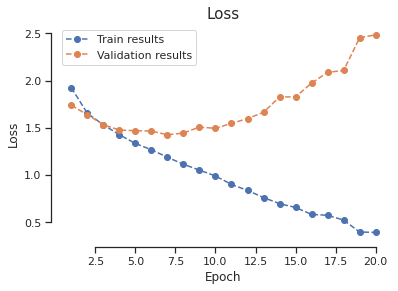

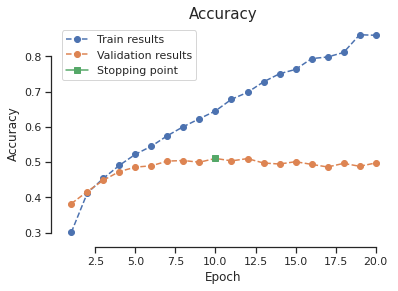

In [19]:
# Your best model:

model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=266, num_hidden_layers=4, act_fn=nn.SiLU)

# top 3 models found:
# {'num_hidden_units': 266, 'num_hidden_layers': 4, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.522}
# {'num_hidden_units': 251, 'num_hidden_layers': 1, 'act_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'accuracy': 0.517}
# {'num_hidden_units': 176, 'num_hidden_layers': 4, 'act_fn': <class 'torch.nn.modules.activation.SiLU'>, 'accuracy': 0.5154}

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
early_stopper = EarlyStopper(patience=10)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=early_stopper
    )
print_best_loss_and_accuracy(val_losses, val_accs)
x, y = np.argmax(val_accs) + 1, max(val_accs)

plot("Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', extra_pt = (x, y), extra_pt_label="Stopping point")

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

We do not get the same performance. One reason for this is random initialisation. We could change this by fixing the initialisation.

The models are still comparible, because retraining the same model usually gave a < 1% difference in results. If the models performed differently this is mostly not due to the initialisation.

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too! *(optional)*

In [28]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """

    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(test_loader, parent=None):
            y_pred = model(x.to(device))
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

    return accuracy(epoch_correct, epoch_total), confusion_matrix
    

Test Accuracy: 0.5093


Text(30.5, 0.5, 'True Label')

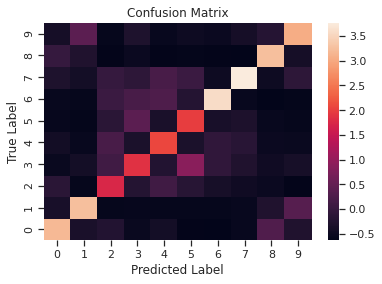

In [32]:
import seaborn as sn

test_acc, confusion_matrix = test(test_dataloader, model, device)

print("Test Accuracy: " + str(test_acc))

confusion_matrix = (confusion_matrix-confusion_matrix.mean())/confusion_matrix.std()
confusion_matrix = confusion_matrix.transpose(0,1)
matrix =sn.heatmap(data=confusion_matrix)
matrix.invert_yaxis()
matrix.set_title("Confusion Matrix")
matrix.set_xlabel('Predicted Label')
matrix.set_ylabel('True Label')

classes = ['airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

*   The model's prediction was poor for bird, cat, deer and dog.
*   The test accuracy was the same as the validation accuracy. (51.02% vs 50.93%)
*   If you use test set performance when trying out different hyper-parameters and architectures you can overfit to the test set, which invalidates the results.

